In [16]:
# pandassql nem támogatja az SQLAlchemy legújabb verzióját, vissza kell redukáni
# különben TraceBack-et dob!!!
pip install SQLAlchemy==1.4.46

  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.18
    Uninstalling SQLAlchemy-2.0.18:
      Successfully uninstalled SQLAlchemy-2.0.18
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] A hozzáférés megtagadva: 'C:\\Users\\Pozsgai Barnabás\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\~qlalchemy\\cyextension\\collections.cp39-win_amd64.pyd'
Check the permissions.

You should consider upgrading via the 'C:\Users\Pozsgai Barnabás\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [35]:
import pandas as pd
import pandasql as sql
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import numpy as np

In [36]:
# 0. Olvasd be az átadott csv kiterjesztésű fájlokat.
# A beolvasott adatokon kell majd elemzési feladatokat végezned, pandasql segítségével.

devices = pd.read_csv('devices.csv', encoding='utf8', sep=";")
display(devices.head())

contract = pd.read_csv('contract.csv', encoding='utf8', sep=";")
display(contract.head())

,CONTRACT_ID,USED_DEVICE
0,1,Xiaomi
1,2,Samsung
2,3,iPhone
3,4,Motorola
4,5,Xiaomi


,CONTRACT_ID,COLL_STATUS,INSTALLATION_DATE,VOICE_SERVICE_NAME,NET_SERVICE_NAME,SEGMENT_GROUP
0,1,0,2010-01-07,Üzleti Hang M,Vállalkozók Netje,ENT
1,2,0,2017-02-27,Üzleti Hang M,Vállalkozók Netje,ENT
2,3,0,2018-06-07,Lakossági Hang XS,Net 5GB,LAK
3,4,0,2016-07-16,Üzleti Hang XL,ÜzlNet 2GB,ENT
4,5,0,2017-07-09,Üzleti Hang M,ÜzlNet 2GB,ENT


In [22]:
# 1.Írj egy lekérdezést, amely visszaadja azon szerződések számát, ahol a szerződés létrehozásának dátuma kisebb mint 2023. Május 1.
query ="""
SELECT
    CONTRACT_ID
FROM
    contract
WHERE
    INSTALLATION_DATE < '2023-05-01';
"""

sql.sqldf(query)

,CONTRACT_ID
0,1
1,2
2,3
3,4
4,5
...,...
49347,49996
49348,49997
49349,49998
49350,49999


In [15]:
# 2. Írj egy lekérdezést, ami visszaadja, hogy a lakossági, valamint az üzleti szerződéseknél milyen arányban fordulnak elő az egyes internet szolgáltatások. Az eredményt rendezt a szegmens alapján csökkenőbe.

query ="""
SELECT
    SEGMENT_GROUP,
    NET_SERVICE_NAME,
    COUNT(*) AS COUNT,
    100.0 * COUNT(*) / SUM(COUNT(*)) OVER (PARTITION BY SEGMENT_GROUP) AS RATIO
FROM
    contract
GROUP BY
    SEGMENT_GROUP,
    NET_SERVICE_NAME
ORDER BY
    SEGMENT_GROUP DESC;
"""

sql.sqldf(query)

,SEGMENT_GROUP,NET_SERVICE_NAME,COUNT,RATIO
0,LAK,Korlátlan Net,6524,33.194261
1,LAK,Net 3GB,6431,32.721075
2,LAK,Net 5GB,6699,34.084665
3,ENT,Vállalkozók Netje,10031,33.055427
4,ENT,ÜzlNet 2GB,10093,33.259738
5,ENT,ÜzlNet Korlátlan,10222,33.684835


In [19]:
# 3. Írj egy lekérdezést amely visszaadja, hogy mely szerződések vannak fizetési elmaradásban, és azok milyen típusú készüléket használnak.
query ="""
SELECT
    contract.CONTRACT_ID,
    devices.USED_DEVICE
FROM
    contract 
INNER JOIN
    devices
ON
    contract.CONTRACT_ID = devices.CONTRACT_ID
WHERE
    contract.COLL_STATUS = 1;
"""

sql.sqldf(query)

,CONTRACT_ID,USED_DEVICE
0,35,Xiaomi
1,108,iPhone
2,112,Huawei
3,147,Samsung
4,229,iPhone
...,...,...
1227,49919,Xiaomi
1228,49929,iPhone
1229,49948,Xiaomi
1230,49953,iPhone


In [64]:
# 4. Írj egy lekérdezést, amely visszaadja, hogy melyik a leggyakrabban előforduló hang szolgáltatás az egyes készülék típusoknál.

query ="""
SELECT
    *
FROM
    (SELECT
        devices.USED_DEVICE,
        COUNT(contract.VOICE_SERVICE_NAME) AS 'NUMBER_OF_MOST_FREQUENT_VALUE',
        contract.VOICE_SERVICE_NAME,
        ROW_NUMBER() OVER (PARTITION BY devices.USED_DEVICE) RANK
    FROM
        contract
    INNER JOIN
        devices
    ON
        contract.CONTRACT_ID = devices.CONTRACT_ID
    GROUP BY
        devices.USED_DEVICE,
        contract.VOICE_SERVICE_NAME
    ORDER BY
        devices.USED_DEVICE,
        contract.VOICE_SERVICE_NAME)
WHERE
    RANK = 1;
"""

voice_df = sql.sqldf(query)
display(voice_df)

,USED_DEVICE,NUMBER_OF_MOST_FREQUENT_VALUE,VOICE_SERVICE_NAME,RANK
0,Huawei,1093,Lakossági Hang Korlátlan,1
1,Motorola,1159,Lakossági Hang Korlátlan,1
2,Oppo,1043,Lakossági Hang Korlátlan,1
3,Samsung,1128,Lakossági Hang Korlátlan,1
4,Xiaomi,1088,Lakossági Hang Korlátlan,1
5,iPhone,1084,Lakossági Hang Korlátlan,1


In [39]:
# Ellenőrzés hogy az sql alapból a leggyakoribb értéket listázza-e ki

query = """
SELECT
    devices.USED_DEVICE,
    contract.VOICE_SERVICE_NAME
FROM
    (SELECT 
        devices.USED_DEVICE,
        contract.VOICE_SERVICE_NAME,
        ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY COUNT(contract.VOICE_SERVICE_NAME) DESC) RANK
    FROM
        contract
    INNER JOIN
        devices
    ON
    contract.CONTRACT_ID = devices.CONTRACT_ID
    GROUP BY
    devices.USED_DEVICE,
    contract.VOICE_SERVICE_NAME)
WHERE
    RANK = 1;
"""

sql.sqldf(query)

PandaSQLException: (sqlite3.OperationalError) no such column: user_id
[SQL: 
SELECT
    devices.USED_DEVICE,
    contract.VOICE_SERVICE_NAME
FROM
    (SELECT 
        devices.USED_DEVICE,
        contract.VOICE_SERVICE_NAME,
        ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY COUNT(contract.VOICE_SERVICE_NAME) DESC) RANK
    FROM
        contract
    INNER JOIN
        devices
    ON
    contract.CONTRACT_ID = devices.CONTRACT_ID
    GROUP BY
    devices.USED_DEVICE,
    contract.VOICE_SERVICE_NAME)
WHERE
    RANK = 1;
]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

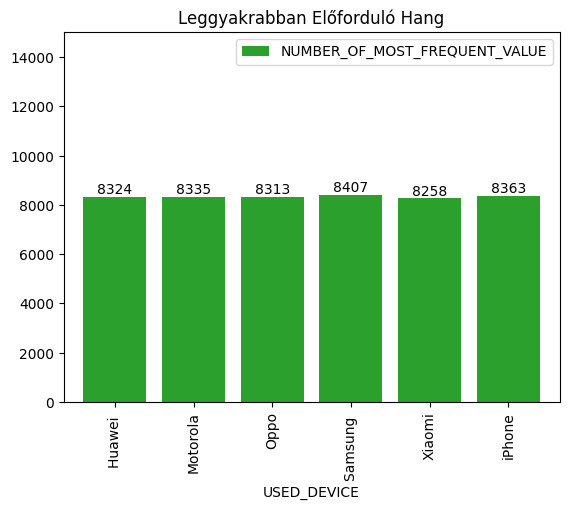

In [179]:
# 5. A 4. feladatban kapott eredmények alapján készíts egy oszlop diagrammot matplotlib segítségével.
# Az x tengelyen legyenek a készülék gyártók nevei, az y tengelyen pedig a visszakapott számok.

ax = (voice_df.plot(
    kind='bar',
    x='USED_DEVICE',
    y='NUMBER_OF_MOST_FREQUENT_VALUE',
    title='Leggyakrabban Előforduló Hang',
    color= 'tab:green',
    width= 0.8))

ax.set_ylim(0, 15000)

rects = ax.patches
labels = voice_df['NUMBER_OF_MOST_FREQUENT_VALUE'].tolist()

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom")
